In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

import matplotlib.pyplot as plt

In [2]:
# dataset
df = pd.read_csv('ethereum_price_model.csv')
df.head()

,Unnamed: 0,Date,Price,Open,High,Low,Vol.,Change %
0,0,2023-03-08,1553.49,1561.79,1569.70,1548.98,498570,-0.53
1,1,2023-03-07,1561.78,1565.84,1580.95,1536.31,460100,-0.26
2,2,2023-03-06,1565.84,1564.36,1581.13,1555.43,322160,0.09
3,3,2023-03-05,1564.37,1566.73,1587.95,1556.84,313010,-0.15
4,4,2023-03-04,1566.73,1569.45,1577.02,1550.10,247020,-0.14


In [4]:
# separate df to training and testing set

# training set
df_train = df.iloc[:2538, 2:3].values

# testing set
df_test = df.iloc[2538:, 2:3].values

In [5]:
# scaling
sc = MinMaxScaler(feature_range = (0, 1))
df_scaled = sc.fit_transform(df_train)

In [6]:
# creating data with timesteps
X_train = []
y_train = []
for i in range(60, 2538):
    X_train.append(df_scaled[i-60:i, 0])
    y_train.append(df_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [7]:
# building the LSTM
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
78/78 [==============================] - 12s 61ms/step - loss: 0.0078
Epoch 2/100
78/78 [==============================] - 5s 63ms/step - loss: 0.0034
Epoch 3/100
78/78 [==============================] - 5s 62ms/step - loss: 0.0031
Epoch 4/100
78/78 [==============================] - 5s 62ms/step - loss: 0.0027
Epoch 5/100
78/78 [==============================] - 5s 60ms/step - loss: 0.0026
Epoch 6/100
78/78 [==============================] - 5s 64ms/step - loss: 0.0023
Epoch 7/100
78/78 [==============================] - 5s 63ms/step - loss: 0.0024
Epoch 8/100
78/78 [==============================] - 5s 64ms/step - loss: 0.0024
Epoch 9/100
18/78 [=====>........................] - ETA: 3s - loss: 0.0021

KeyboardInterrupt: 

In [8]:
# predictions, reformatting to readable format

df_pred = df['Price']
inputs = df_pred[len(df) - len(df_test) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

X_test = []
for i in range(60, 76):
    X_test.append(inputs[i - 60:i, 0])

X_test = [x.tolist() for x in X_test]
length = max(map(len, X_train))
X_test = np.array([x + [0] * (length - len(x)) for x in X_test])

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))



predicted_eth_price = regressor.predict(X_test)
predicted_eth_price = sc.inverse_transform(predicted_eth_price)

1/1 [==============================] - 1s 1s/step


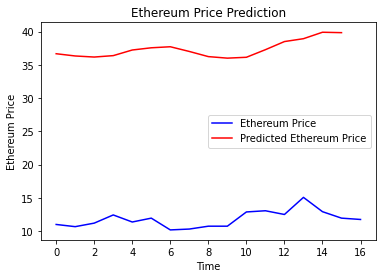

In [9]:
# results
plt.plot(df_test, color = 'blue', label = 'Ethereum Price')
plt.plot(predicted_eth_price, color = 'red', label = 'Predicted Ethereum Price')
plt.title('Ethereum Price Prediction')
plt.xlabel('Time')
plt.ylabel('Ethereum Price')
plt.legend()
plt.show()